# FIO plots

In [1]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

In [2]:
def bw_ios3(filename, fiorw, option):
    '''
    Function to read BW or IOPS from a json file
    
    Input:
        filaname :: json name file (include the path)
        fio      :: read, write, etc.
        option   :: iops, bw_bytes, runtime, etc. 
    NOTE: All the inputs are str type.
    '''
    with open(filename) as f:
        data = json.load(f)
    return data['jobs'][0][fiorw][option]

In [3]:
def plot_bw_iops(HOME, nodes, fiojobs):
    '''
    Function to plot total BW & IOPS using HOME files for n nodes and n fio_jobs
    '''
    #Plot environment
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 6))

    dataset = [{"data": []}]
    
    histo = []
    for fjob in fiojobs:
        total_flow = []
        total_fio_bw = []
        total_fio_iops = []
        
        for node in nodes:
            path=HOME+str(node)+'_node/'
            content=os.listdir(path)
            fiojob = [s for s in content if "fiojob_"+str(fjob) in s]
            
            if len(fiojob)>1:
                if len(fiojob[0])<len(fiojob[1]): fiojob=fiojob[0]
                else: fiojob = fiojob[1]
            else:
                fiojob= fiojob[0]
            
            fio_bw = 0
            fio_iops = 0
            fio_jobs = 0
            
            for folder in os.listdir(path+fiojob):

                fio_bw+= bw_ios3(path+fiojob+"/"+folder+"/output.json","read", 'bw_bytes')*1e-6 #in Mb/s
                fio_iops+= bw_ios3(path+fiojob+"/"+folder+"/output.json", "read", 'iops')*1e-3      #in k
                #fio_jobs+= bw_ios3(path+fiojob+"/"+folder+"/output.json", " ", 'numjobs')*1e-3      #in k
                fio_jobs+=fjob
                
            total_fio_bw.append(fio_bw)
            total_fio_iops.append(fio_iops)
            histo.append(fio_bw)

        #plt.plot(nodes,total_flow, '--',label='fio_tjob='+str(fjob))
        ax[0].plot(nodes,total_fio_bw,'o--',label='fio_job='+str(fjob))
        ax[1].plot(nodes,total_fio_iops,'o--',label='fio_job='+str(fjob))                 
        
    ax[0].legend()
    ax[0].set_xticks(nodes)
    ax[0].set_xlabel('nodes', size=16)
    ax[0].set_ylabel('MB/s', size=16)
    ax[0].set_title("Total Bandwidth vs. n nodes", size=20)

    ax[1].legend()
    ax[1].set_xticks(nodes)
    ax[1].set_xlabel('nodes')
    ax[1].set_ylabel('kIOPS')
    ax[1].set_title("Total IOPS vs. n nodes")
    plt.show()
    
    plot_3d(nodes, fiojobs, histo)
    

In [4]:

def plot_3d(nodes, numjobs, data):
    """This function is responsible for plotting the entire 3D plot."""


    iodepth = nodes
    numjobs = fiojobs
    z_axis_label = 'Bandwidth MB/s'
    
    fig = plt.figure()
    ax1 = fig.add_subplot(projection="3d", elev=25)
    fig.set_size_inches(15, 10)
    ax1.set_box_aspect((4, 4, 3), zoom=1.2)

    lx = len(nodes)
    ly = len(numjobs)

    n = np.array(data, dtype=float)

    if lx < ly:
        size = ly * 0.03  # thickness of the bar
    else:
        size = lx * 0.05  # thickness of the bar

    xpos_orig = np.arange(0, lx, 1)
    ypos_orig = np.arange(0, ly, 1)

    xpos = np.arange(0, lx, 1)
    ypos = np.arange(0, ly, 1)
    xpos, ypos = np.meshgrid(xpos - (size / lx), ypos - (size * (ly / lx)))

    xpos_f = xpos.flatten()  # Convert positions to 1D array
    ypos_f = ypos.flatten()

    zpos = np.zeros(lx * ly)

    # Positioning and sizing of the bars
    dx = size * np.ones_like(zpos)
    dy = size * (ly / lx) * np.ones_like(zpos)
    dz = n.flatten(order="F")
    values = dz / (dz.max() / 1)

    # Create the 3D chart with positioning and colors
    cmap = plt.get_cmap("rainbow", xpos.ravel().shape[0])
    colors = cm.rainbow(values)
    ax1.bar3d(xpos_f, ypos_f, zpos, dx, dy, dz, color=colors, zsort="max")

    # Create the color bar to the right
    norm = mpl.colors.Normalize(vmin=0, vmax=dz.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    res = fig.colorbar(sm, fraction=0.046, pad=0.19)
    res.ax.set_title(z_axis_label)

    # Set tics for x/y axis
    float_x = [float(x) for x in (xpos_orig)]

    ax1.w_xaxis.set_ticks(float_x)
    ax1.w_yaxis.set_ticks(ypos_orig)
    ax1.w_xaxis.set_ticklabels(iodepth)
    ax1.w_yaxis.set_ticklabels(numjobs)

    # axis labels
    fontsize = 16
    ax1.set_xlabel("nodes", fontsize=fontsize)
    ax1.set_ylabel("fiojob", fontsize=fontsize)
    ax1.set_zlabel(z_axis_label, fontsize=fontsize)

    [t.set_verticalalignment("center_baseline") for t in ax1.get_yticklabels()]
    [t.set_verticalalignment("center_baseline") for t in ax1.get_xticklabels()]

    ax1.zaxis.labelpad = 25

    tick_label_font_size = 12
    for t in ax1.xaxis.get_major_ticks():
        t.label.set_fontsize(tick_label_font_size)

    for t in ax1.yaxis.get_major_ticks():
        t.label.set_fontsize(tick_label_font_size)

    ax1.zaxis.set_tick_params(pad=10)
    for t in ax1.zaxis.get_major_ticks():
        t.label.set_fontsize(tick_label_font_size)


    plt.show()

In [5]:
def plot_bw_iops3(HOME, nodes, fiojobs):
    '''
    Function to plot total BW & IOPS using HOME files for n nodes and n fio_jobs
    '''
    #Plot environment
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))
    

    for fjob in fiojobs:
        total_flow = []
        total_fio_bw_r = []
        total_fio_bw_w = []
        total_fio_iops_r = []
        total_fio_iops_w = []
        
        for node in nodes:
            path=HOME+str(node)+'_node/'
            content=os.listdir(path)
            fiojob = [s for s in content if "fiojob_"+str(fjob) in s]
            
            if len(fiojob)>1:
                if len(fiojob[0])<len(fiojob[1]): fiojob=fiojob[0]
                else: fiojob = fiojob[1]
            else:
                fiojob= fiojob[0]
            
            flow_node = 0
            fio_bytes_r, fio_bytes_w = 0, 0 
            fio_iops_r, fio_iops_w   =  0, 0
            
            for folder in os.listdir(path+fiojob):
                #print(path+fiojob+"/"+folder)
                fio_bytes_r += bw_ios3(path+fiojob+"/"+folder+"/output.json","read", 'bw_bytes')*1e-6  #in Mb/s
                fio_bytes_w += bw_ios3(path+fiojob+"/"+folder+"/output.json","write", 'bw_bytes')*1e-6 #in Mb/s
                fio_iops_r += bw_ios3(path+fiojob+"/"+folder+"/output.json", "read", 'iops')*1e-3  #in k
                fio_iops_w += bw_ios3(path+fiojob+"/"+folder+"/output.json", "write", 'iops')*1e-3 #in k
                
            total_fio_bw_r.append(fio_bytes_r)
            total_fio_bw_w.append(fio_bytes_w)
            total_fio_iops_r.append(fio_iops_r)
            total_fio_iops_w.append(fio_iops_w)

            
        #plt.plot(nodes,total_flow, '--',label='fio_tjob='+str(fjob))
        ax[0,0].plot(nodes,total_fio_bw_r,'o--',label='fio_job='+str(fjob))
        ax[1,0].plot(nodes,total_fio_iops_r,'o--',label='fio_job='+str(fjob))
        
        ax[0,1].plot(nodes,total_fio_bw_r,'o--',label='fio_job='+str(fjob))
        ax[1,1].plot(nodes,total_fio_iops_w,'o--',label='fio_job='+str(fjob))

    ax[0,0].legend()
    ax[0,0].set_xticks(nodes)
    ax[0,0].set_xlabel('nodes')
    ax[0,0].set_ylabel('MB/s')
    ax[0,0].set_title("READ: Bandwidth vs. n nodes")

    #ax[1,0].legend()
    ax[1,0].set_xticks(nodes)
    ax[1,0].set_xlabel('nodes')
    ax[1,0].set_ylabel('kIOPS')
    ax[1,0].set_title("READ: IOPS vs. n nodes")
    
    #ax[0,1].legend()
    ax[0,1].set_xticks(nodes)
    ax[0,1].set_xlabel('nodes')
    ax[0,1].set_ylabel('MB/s')
    ax[0,1].set_title("WRITE: Total Bandwidth vs. n nodes")

    #ax[1,1].legend()
    ax[1,1].set_xticks(nodes)
    ax[1,1].set_xlabel('nodes')
    ax[1,1].set_ylabel('kIOPS')
    ax[1,1].set_title("WRITE: IOPS vs. n nodes")
    
    plt.show()

# SEQREAD  plots

## W/O SARUS: IODEPTH = 32, DIRECT = 1, BS =4K

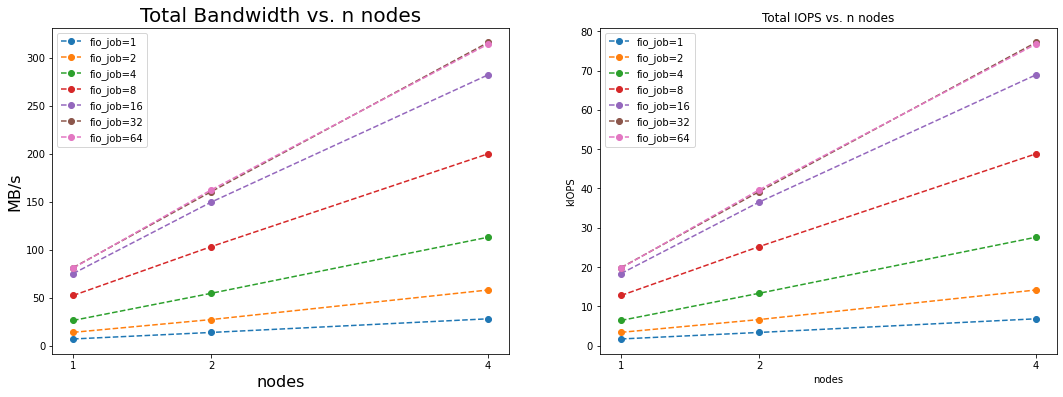

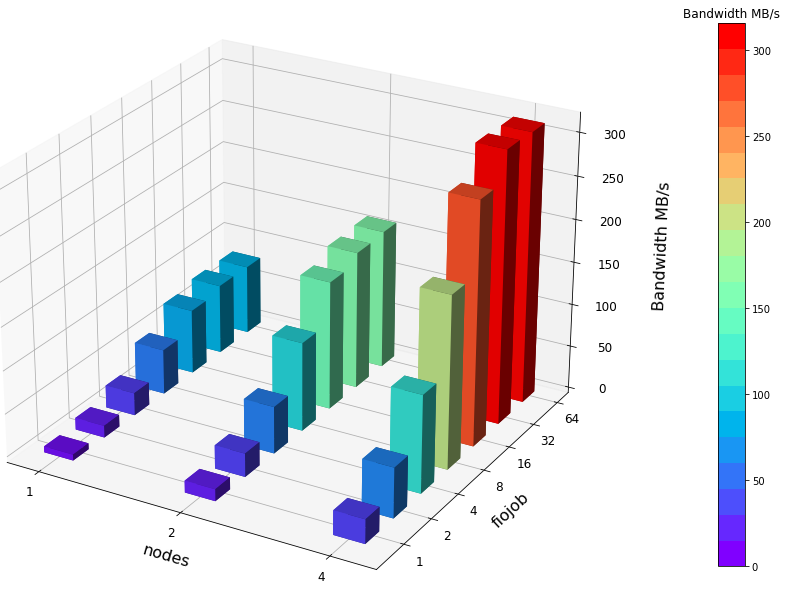

In [6]:
# SEQ_READ#
HOME_seqread = "/home/ccochato/Desktop/Computing/HPC/PROJECT/FIO/fio-test/seqread/IODEPTH_32_DIRECT_1/"
nodes = [1, 2, 4]
fiojobs = [1,2, 4, 8, 16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)

## SARUS: IODEPTH = 32, DIRECT = 1, BS =4K

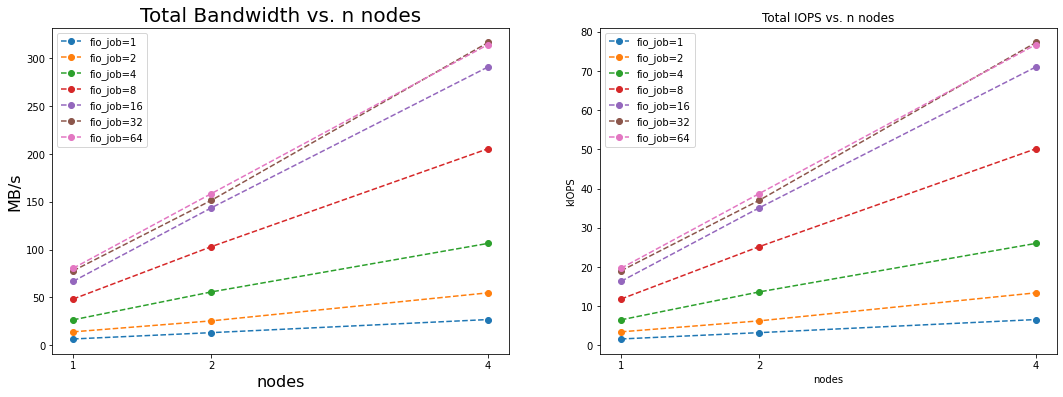

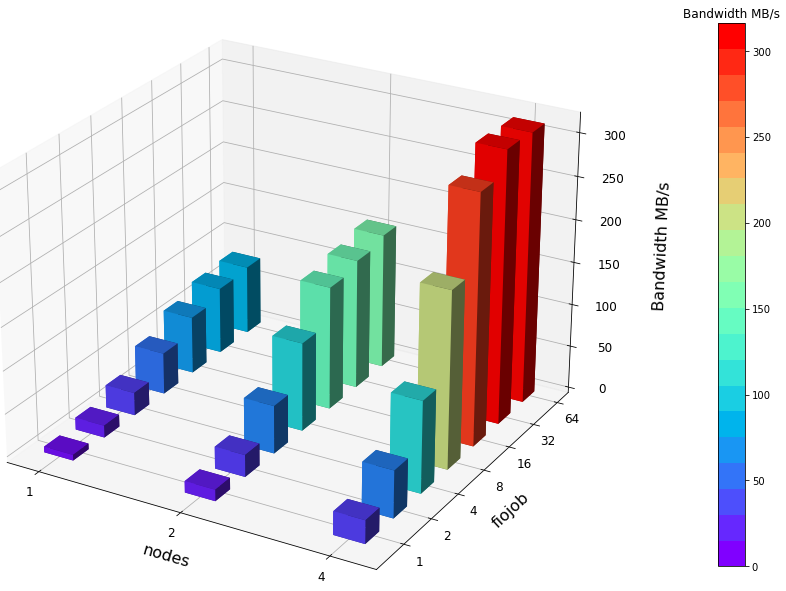

In [7]:
# SEQ_READ#
HOME_seqread = "/home/ccochato/Desktop/Computing/HPC/PROJECT/CONTAINER_TEST2/RUN_IODEPTH_32_DIRECT_1_BS_4/"
nodes = [1,2, 4]
fiojobs = [1,2, 4, 8, 16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)

## NO SARUS: IODEPTH = 256, DIRECT = 1, BS=4K

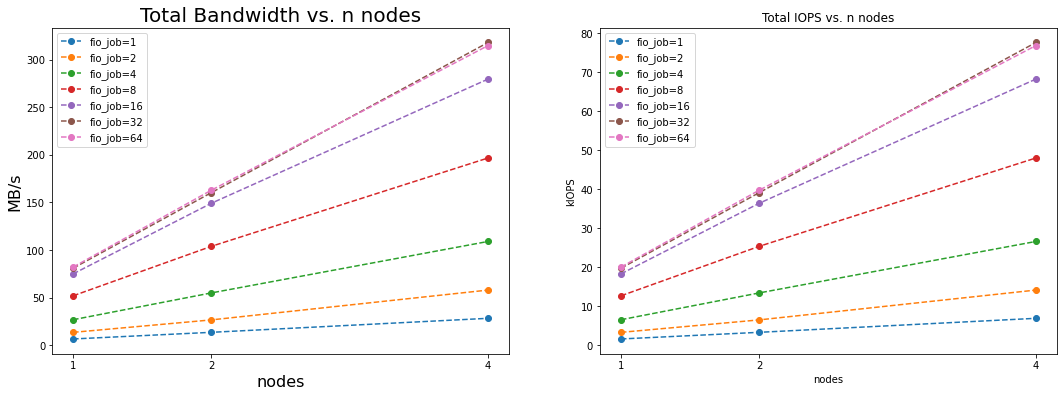

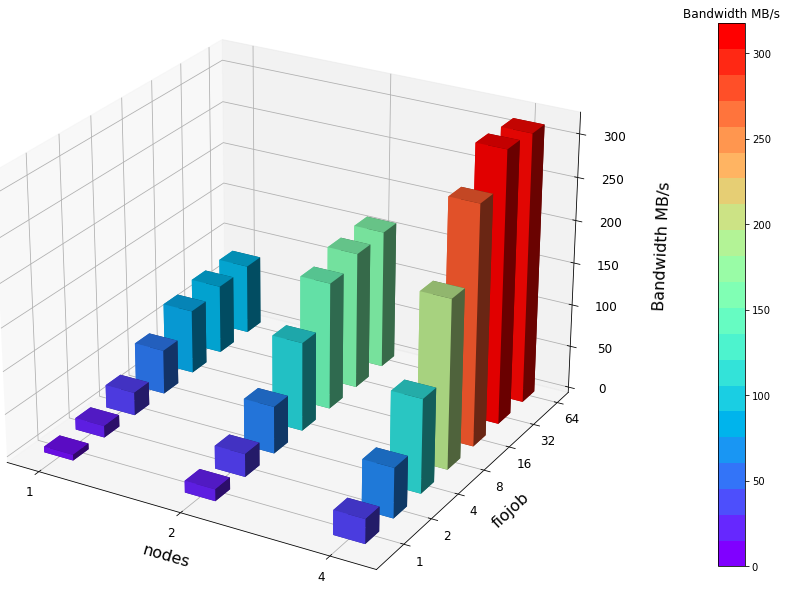

In [8]:
HOME_seqread = "/home/ccochato/Desktop/Computing/HPC/PROJECT/FIO/fio-test/seqread/IODEPTH_256_DIRECT_1/"
nodes = [1, 2, 4]
fiojobs = [1,2, 4, 8,16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)

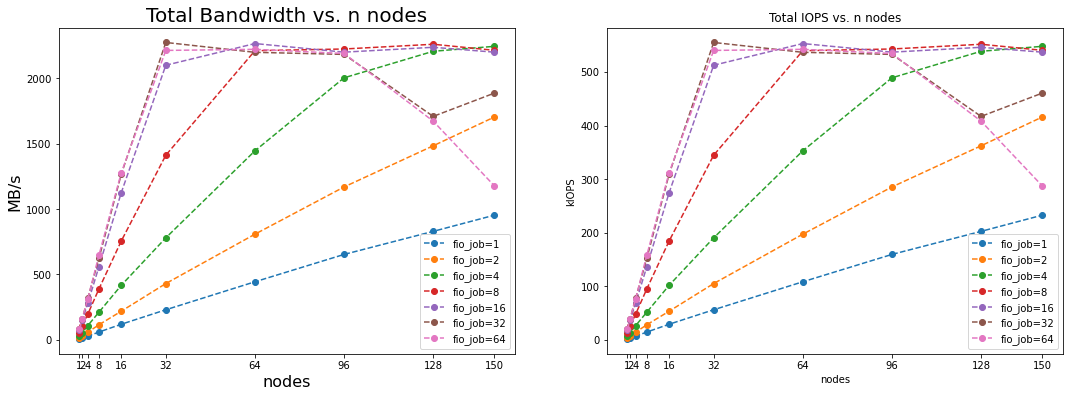

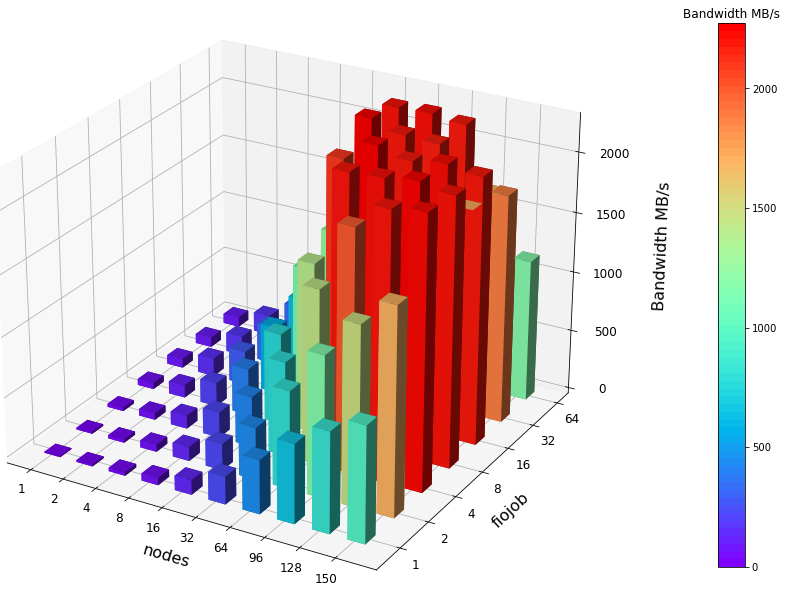

In [9]:
nodes = [1, 2, 4, 8,16, 32, 64, 96, 128, 150]
fiojobs = [1,2, 4, 8,16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)

## IODEPTH = 256, DIRECT = 1, BS=8K

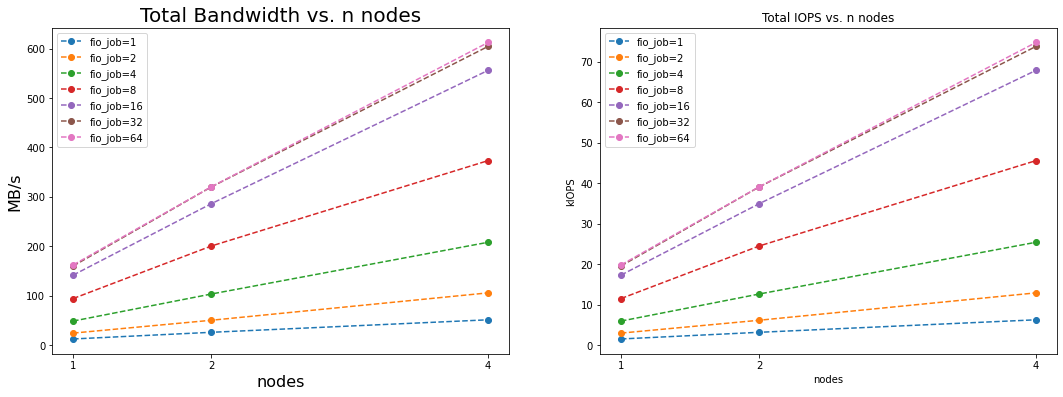

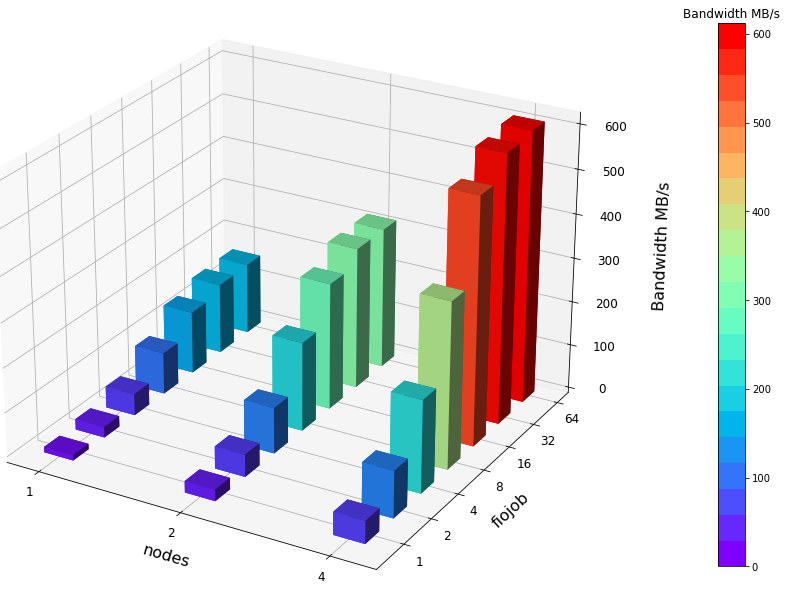

In [10]:
HOME_seqread = "/home/ccochato/Desktop/Computing/HPC/PROJECT/FIO/fio-test/seqread/IODEPTH_32_BS_8_DIRECT_1/"
nodes = [1, 2, 4]
fiojobs = [1,2, 4, 8,16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)

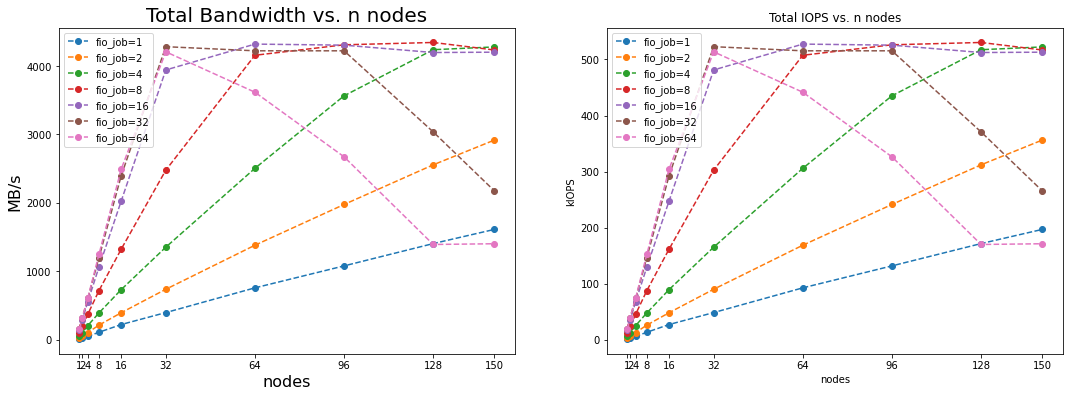

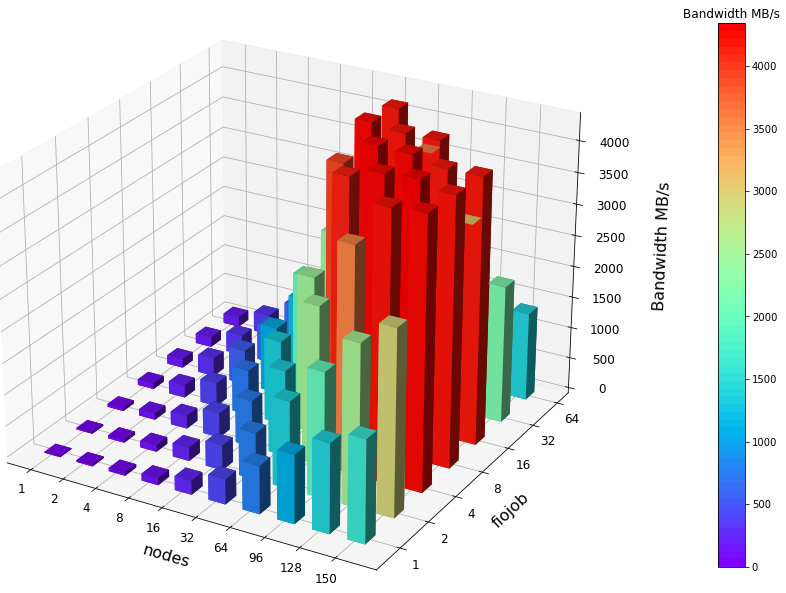

In [11]:
nodes = [1, 2, 4, 8, 16, 32, 64, 96, 128, 150]
fiojobs = [1,2, 4, 8,16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)

## IODEPTH = 256, DIRECT = 1, BS=16K

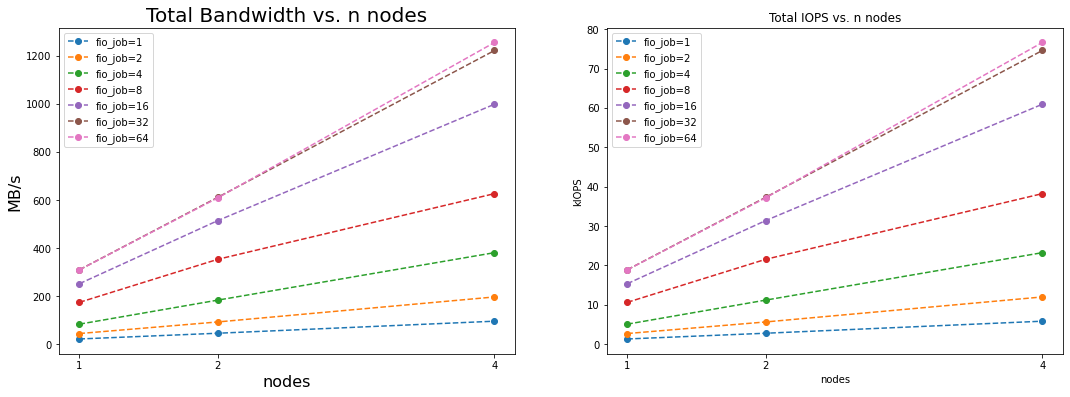

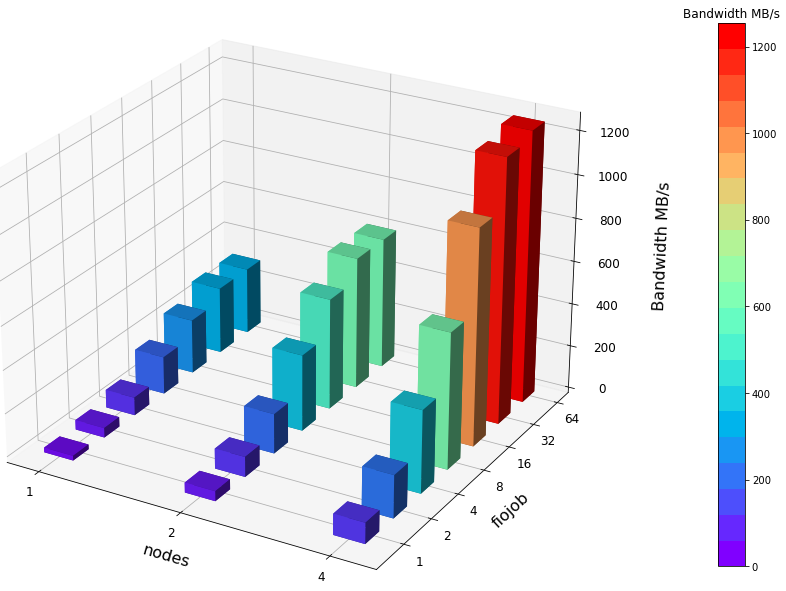

In [12]:
HOME_seqread = "/home/ccochato/Desktop/Computing/HPC/PROJECT/FIO/fio-test/seqread/RUN_IODEPTH_256_DIRECT_1_BS_16/"
nodes = [1, 2, 4]
fiojobs = [1,2, 4, 8,16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)

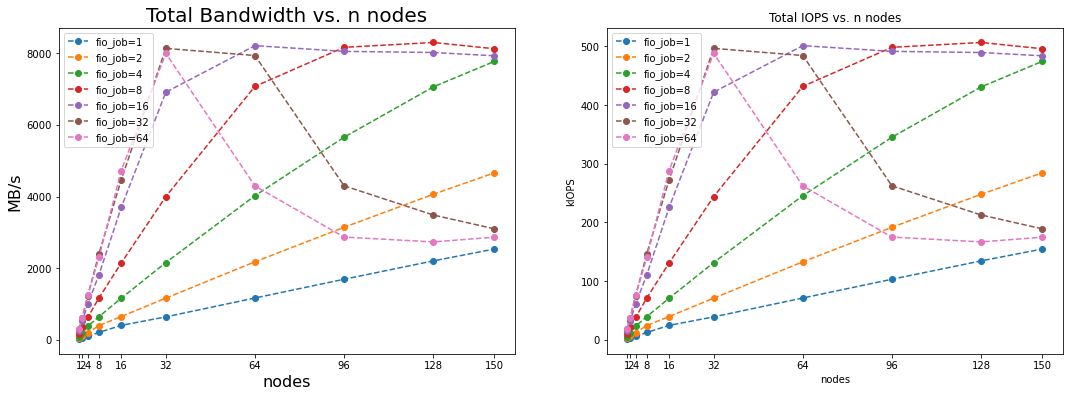

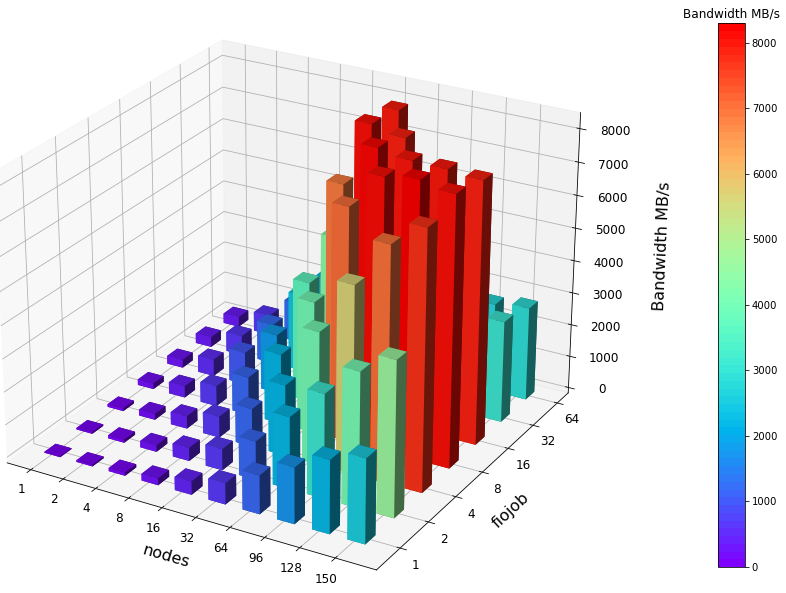

In [13]:
nodes = [1, 2, 4, 8,16, 32, 64, 96, 128, 150]
fiojobs = [1,2, 4, 8,16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)

## IODEPTH = 256, DIRECT = 0

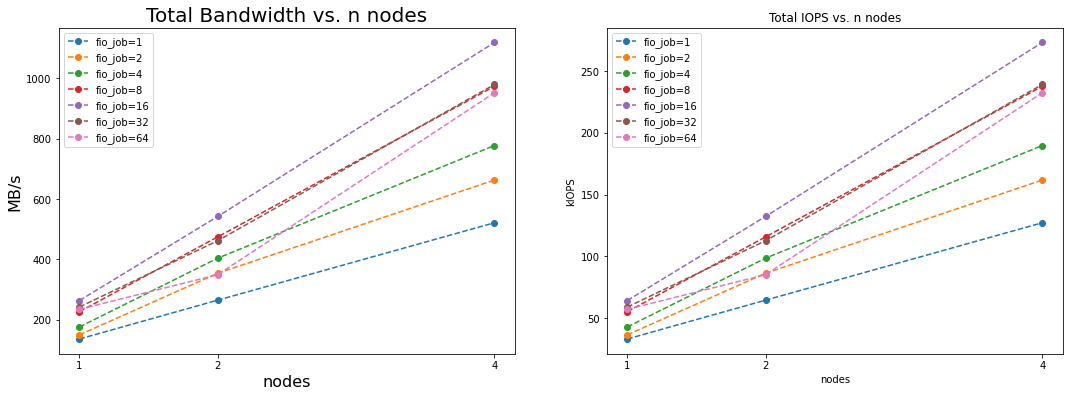

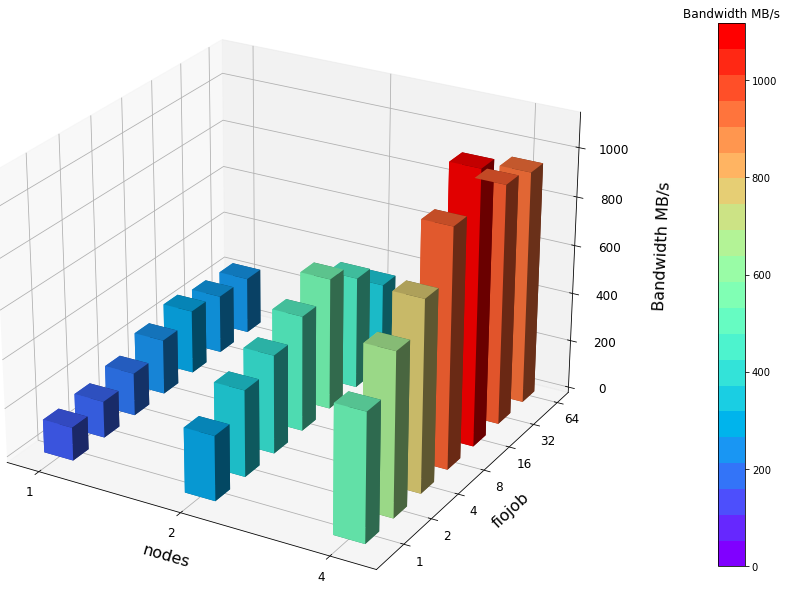

In [14]:
# SEQ_READ
HOME_seqread = "/home/ccochato/Desktop/Computing/HPC/PROJECT/FIO/fio-test/seqread/"
nodes = [1, 2, 4]
fiojobs = [1,2, 4, 8,16, 32, 64]
plot_bw_iops(HOME_seqread, nodes, fiojobs)